# Package introductory notebook: implementing your own PDE problem

## Reminder on the mathematical context

A detailed introduction on learning PDE with PINNs is available in the [Background section](https://mia_jinns.gitlab.io/jinns/maths/introduction_to_pinns/) of the documentation. We simply recall the general statement: we wish to learn a solution $u$ to a PDE driven by the a differential operator $\mathcal{N}_\theta$ on a space domain $\Omega \subset \mathbb{R}^d$, a time interval $I = [0, T]$, with possible border condition on $\partial \Omega$ and initial condition $u(0, x) = u_0(x)$.

$$
\begin{equation}
\begin{cases}
\tag{PDE}
& \mathcal{N}_\theta[u](t, x) = 0, \quad \forall  t, x \in I\times \Omega, & \textrm{(Dynamic)}\\
& u(0, \cdot) = u_0(x), \quad \forall x \in \omega & \textrm{(Initial condition)} \\
& \mathcal{B}[u](t, dx) = f(dx), \quad \forall dx \in \partial \Omega, \forall t \in I & \textrm{(Boundary condition)}
\end{cases}
\end{equation}
$$

We wish to learn an estimator of the true solution $\hat{u}$ in the form of a parametric neural network with weights and biases $\nu$. The **jinns** package solves optimization of the following form:

$$
\hat{u} = u_{\hat{\nu}}\quad \textrm{with:} \quad \hat{\nu} \in \arg \min_{\nu} \left\{ L(\nu) = \Vert  \mathcal{N}_\theta[u_\nu] \Vert^2_{dyn} + w_{init} \Vert u_{\nu}(\cdot, 0) - u_0 \Vert^2_{init} + w_b \Vert \mathcal{B}[u_{\nu}] - f \Vert^2_{border} \right\},
$$

where $\Vert \cdot \Vert^2$ denotes an MSE on randomly sampled collocation points. We use stochastic gradient on mini-batches of $\Omega$, $\partial \Omega$ and $I$.

## Solving forward PDE problems with jinns

This tutorial focuses on solving forward problem with **jinns**. In order to define their PDE problem, a user needs to define:

 1. The neural network $u_\nu$ : **jinns** provides utility function to create a multi-layer perceptron as an [Equinox](https://pypi.org/project/equinox/) module.
 2. A `DataGenerator` object that handles the generation of the mesh on $I$, $\Omega$, $\partial \Omega$.
 3. A so-called `DynamicLoss`, which is an object defining the differential operator $\mathcal{N}_\theta[u_\nu]$, *i.e.* the PDE *dynamic* part of the global loss.
 4. The global loss $L_{PINN}(\nu)$ which includes the boundary condition and initial condition.
 5. An optimization solver

We go through all these steps using the toy example of the 1-D Burgers equation defined on $I \times \Omega = [0, T] \times [-1, 1]$ as:

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
          u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0,\\
          u(0, x) = -\sin(\pi x), & \textrm{ (Initial condition)}\\
u(t,-1)=u(t,1)=0, & \textrm{ (Boundary condition)}
\end{cases}
$$

where $\theta = 0.01 \pi$ is a single scalar equation parameters in this example.

We emphasize that in-depth Notebooks are available for several 2-D stationary and non-stationary PDEs:

 * FisherKPP
 * Burgers Equation
 * Navier-Stokes
 * Fokker-Planck equation to find the p.d.f. of an Ornstein-Ulhenbeck process

### Setup 

We begin by importing the necessary packages

In [1]:
import jinns
import jax
import jax.random as random
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt

In [2]:
nu = 1 / (100 * jnp.pi)

### Setting the random key in JAX

If you are new to JAX, we recommand reading the documentation on [pseudo-random number generation](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html#pseudo-random-numbers-in-jax) and the differences with NumPy.

In [3]:
key = random.PRNGKey(42)

### Defining your neural network 

The **jinns** package requires a function $u(\{t, x\}, \nu, \theta)$ where $\nu$ are the neural network parameters, while $\theta$ are the equation parameters. Of course, the user is free to make the network depend on $\theta$ or not.

The following block-cells defines the function $u_\nu = f_{1, \nu} \circ \ldots \circ f_{L, \nu}$ where $L$ is the number of layers, and $f_{i, \nu}(x) = \sigma(A_ix + b_i)$ are simple linear functions followed by a non-linearity $\sigma$. We will work with the [equinox](https://pypi.org/project/equinox/) package which has PyTorch-like API but creates objects compatible with JAX-transformations - known as PyTrees - which is required.

In this example, we choose arbitrarily $L=4$, with 20 neurons for each layer and activation $\sigma = \textrm{tanh}$. The dimension of the input $\{t, x\}$ is $d+1 = 2$. 

To do this, we use the `jinns.nn` module which enables creating PINNs. Note the use of the `PINN_MLP.create()` class method to ease PINN instanciation.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 2, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=key, eqx_list=eqx_list, eq_type="nonstatio_PDE"
)

We have just created an object from the `PINN` class and retrieved an initial set of parameters. The PINN can be evaluated with `u(inputs, params)`, with `inputs` being a collocation point (the concatenation of a time point `t` and a space point `x`), which evaluates the neural net at points `t` and `x`. The weights and biases are located at the field `params.nn_params`

Below we show how to evaluate the neural network with random initialization

In [5]:
u_init = lambda t_x: u(t_x, init_nn_params)
u_init(jnp.zeros((2,)))  # u_init({0, 0})

Array([0.17611018], dtype=float32)

We then proceed to the creation of the initial parameters `params` object which is to be fed to the loss. It contains both $\nu$ and $\theta$, which are stored in the field `nn_params` and `eq_params` respectively.

> **Note**: even though equation parameters $\theta$ are fed to `evaluate()` they will be static for the optimization process (forward process).

In [6]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,  # network parameters
    eq_params={"nu": nu},  # equation parameters
)

### Defining the mesh on $\Omega$, $\partial \Omega$ and $I$ : the DataGenerator class

Here, the space domain $\Omega = [-1, 1]$ and $\partial \Omega = \{-1, 1\}$ and the time domain is $I = [0, T]$. We will define an object that will allow to sample mini-batches from $I\times\Omega$ and from $I\times\partial\Omega$. Here $\Omega$ and $I$ are sampled uniformly, but a regular grid is also possible. Note, that it is also common to put the batch sizes to `None`, thus avoinding the stochastic part of the gradient descent. This consideration is very problem-specific and also affects **jinns** performances, for better or for worse, depending on the other hyperparameters.

In [7]:
n = 6000
ni = 3000
nb = 3000
domain_batch_size = 512
initial_batch_size = 256
border_batch_size = 256
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/data/_CubicMeshPDENonStatio.py:214: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.ni = 3000). Modifying self.ni to self.ni = 3025.
  warnings.warn(


`train_data` is an `eqx.Module` implementing a `.get_batch()` method which returns a length 2 tuple 
 * a modified instance of the Module, updating its inner state. This is because JAX does not allow in-place modification of `train_data` in jit-compiled computation.
 * a `PDENonStatioBatch` which is another `eqx.Module` with fields containing the cartesian products of collocation points in
    1. $I \times \Omega$  
    2. $I \times \partial \Omega$

In [8]:
print("The domain has a total shape of", train_data.domain.shape)

train_data, batches = train_data.get_batch()
batches

The domain has a total shape of (6000, 2)


PDENonStatioBatch(
  domain_batch=f32[512,2],
  border_batch=f32[256,2,2],
  initial_batch=f32[256,1],
  param_batch_dict=None,
  obs_batch_dict=None
)

In [9]:
print(
    "Each batch has shape :\n",
    f"{batches.domain_batch.shape=}",
    "\n",
    f"{batches.border_batch.shape=}",
)

Each batch has shape :
 batches.domain_batch.shape=(512, 2) 
 batches.border_batch.shape=(256, 2, 2)


**Note:** Currently, the packages only implements a cubic mesh $\prod_{j=1}^d \left[x_{min}^j, x_{max}^j\right]$ for $\Omega$. In general cases, $\Omega$ and its border may be complicated sets. The **jinns** package allows users to define their own `DataGenetorPDE` according to their needs. However, we emphasize that any user implementation needs to be *jit-able* by JAX, thus requiring to be familiar with advanced JAX notions such as tracing and [custom PyTrees](https://jax.readthedocs.io/en/latest/pytrees.html#custom-pytrees-and-initialization). In general, we recommend subclassing `eqx.Module` as they are directly registered as PyTree.

**Advanced:** notice that the border batch's shape is `(128,2,2)`, the last dimension represents the facet (here the two extremity points of the 1D space domain).

### Defininition of your PDE: the PINN loss
In order to define the loss $L(\nu)$, the package procede in two-step.

  1. A `DynamicLoss` defines the differential operator $\mathcal{N}_\theta[u_\nu] = 0$, defining the PDE dynamic.
  2. The `LossPDENonStatio` class creates $L_{PINN}$ by gathering the dynamic loss with other terms: here, the boundary and initial conditions.
    
#### The PDE dynamic : the DynamicLoss class
 **Note:** The Burgers equation's dynamic loss is already implemented in the `jinns.loss`, but we recreate one simple version for the sake of illustration.

The important things to notice are:

 * The code uses JAX autodiff via the `grad` method to compute partial derivatives w.r.t. $t$ and $x$. See the [JAX autodiff cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) for more advanced features.
 * The `equation(self, t_x, u, params)` method computes $\mathcal{N}_\theta[u_\nu](t, x)$, allowing $\theta$ as input.

In [10]:
from jinns.loss import PDENonStatio

from jaxtyping import Float, Array

import jinns.parameters


class BurgersEquation(PDENonStatio):
    r"""
    Return the Burgers dynamic loss term (in 1 space dimension):

    $$
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0
    $$
    """

    def equation(
        self,
        t_x: Float[Array, "1+dim"],
        u: eqx.Module,
        params: jinns.parameters.Params,
    ) -> Float[Array, "1"]:
        r"""
        Evaluate the dynamic loss at :math:`(t,x)`.

        Parameters
        ---------
        t_x
            A collocation point in $I\times\Omega$
        u
            The PINN
        params
            The dictionary of parameters of the model.
        """
        u_ = lambda t_x: jnp.squeeze(u(t_x, params)[u.slice_solution])
        du_dtx = jax.grad(u_)
        d2u_dx_dtx = jax.grad(lambda t_x: du_dtx(t_x)[1])
        du_dtx_values = du_dtx(t_x)

        return du_dtx_values[0:1] + self.Tmax * (
            u_(t_x) * du_dtx_values[1:2] - params.eq_params["nu"] * d2u_dx_dtx(t_x)[1:2]
        )


be_loss = BurgersEquation(Tmax=1)

#### The global PINN loss $L$ : `LossPDENonStatio` class

Once you created your PINN and `DynamicLoss`, **jinns** automatize the remaining step of creating $L_{PINN}$. You only need to 

 * design loss weights to balance between the different terms.
> **Adaptative loss weights** : for the completeness of this example, we will use the SoftAdapt procedure to automatically update the loss weights for improved learning. We do so by using the field `update_weight_method` of the `LossPDENonStatio` class.

 * define the boundary operator $\mathcal{B}$, here the identity (Dirichlet). The package also proposes Von Neumann condition.
 * define the boundary term $f$ on $\partial \Omega$, here it is the constant $f=0$. Note that this function must have a signature `f(t_dx)` event if one is unused.
 * define the initial condition : $u_0$.

> **Advanced** : the package allows finer control on the gradients for the loss. An attribute `derivative_keys`, not used here, applies `jax.lax.stop_gradient` to *some* parameters of the `Params` object. This allows to control the optimization procedure, telling if the gradient are taken w.r.t. to $\nu$, $\theta$ or both. See the documentation and the inverse problem tutorial for more details.

In [11]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1,  # w_dyn
    initial_condition=1,  # w_init
    boundary_loss=1,  # w_b
)


omega_boundary_fun = lambda t_dx: 0


def u0(x):
    return -jnp.sin(jnp.pi * x)


# Define the global loss combining everything together
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    update_weight_method="ReLoBRaLo",
    dynamic_loss=be_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
    params=init_params,
)

The `LossPDENonStatio` class implements an `evaluate(params, batch)` method which computes $L(\nu, \theta; \mathcal{B})$, where `batch` is a batch returned by `DataGenerator.get_batch()`. 


In [12]:
# Testing the loss function

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
train_data, batch = train_data.get_batch()
losses, grads = losses_and_grad(init_params, batch=batch)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")
print("Gradient with respect to eq_params should be 0 here: ", grads.eq_params)

total loss: 0.66
Individual losses: {'dyn_loss': '0.00', 'boundary_loss': '0.08', 'initial_condition': '0.57'}
Gradient with respect to eq_params should be 0 here:  {'nu': Array(0., dtype=float32, weak_type=True)}


### Final step : learning the PINN parameters with the `solve()` function

We are now equipped with all we need to proceed to the minimization of $L$ w.r.t. $\nu$ via stochastic gradient descent on mini-batches of $\omega \times \partial \Omega \times I$.

We will use the [optax](https://pypi.org/project/optax/) package to define the algorihtm (here ADAM with steps-size`$0.001`).

The `solve()` function easily combines your optimization objective, the data generator and your loss and learns the PINN parameters, as demonstrated below. 

In [13]:
### Schedule your optimization algorithm
tx = optax.adam(learning_rate=1e-3)

In [14]:
key, subkey = random.split(key, 2)
n_iter = int(100000)
params = init_params

In [15]:
### call the `solve` method


params, total_loss_list, loss_by_term_dict, _, _, _, _, stored_weight_terms, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
        print_loss_every=5000,
    )
)


Compilation took
 6.942385673522949 

[train] Iteration 0: loss value = 0.6411086320877075
[train] Iteration 5000: loss value = 0.027947790920734406
[train] Iteration 10000: loss value = 0.0207156240940094
[train] Iteration 15000: loss value = 0.009671298786997795
[train] Iteration 20000: loss value = 0.005073560401797295
[train] Iteration 25000: loss value = 0.0012392866192385554
[train] Iteration 30000: loss value = 0.0032979478128254414
[train] Iteration 35000: loss value = 0.004295730963349342
[train] Iteration 40000: loss value = 0.0028413990512490273
[train] Iteration 45000: loss value = 0.001833280548453331
[train] Iteration 50000: loss value = 0.001021679025143385
[train] Iteration 55000: loss value = 0.001504367683082819
[train] Iteration 60000: loss value = 0.0010683974251151085
[train] Iteration 65000: loss value = 0.0008162112208083272
[train] Iteration 70000: loss value = 0.0011109623592346907
[train] Iteration 75000: loss value = 0.00040042653563432395
[train] Iteration 

### Visualisation of the estimated PINN

You can plot the evolution of the different losses and the global loss

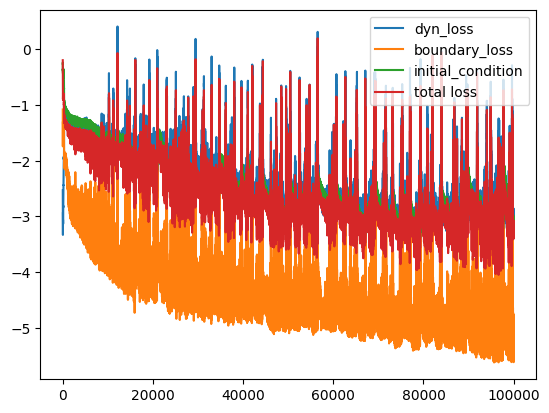

In [16]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Let's also visualize the loss weight values along the iterations

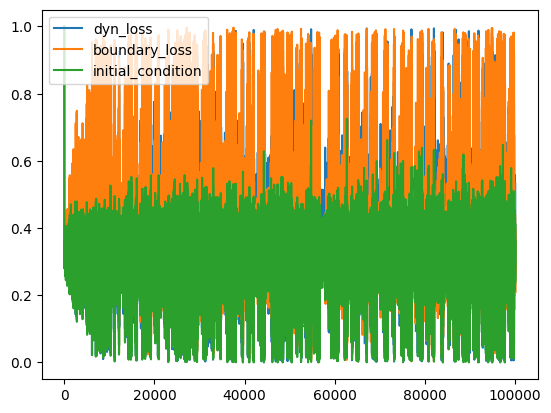

In [17]:
for loss_name, weight_values in stored_weight_terms.items():
    plt.plot(weight_values, label=loss_name)
plt.legend()
plt.show()

(<Figure size 1000x1000 with 2 Axes>, <Axes: title={'center': 'u(t, x)'}>)

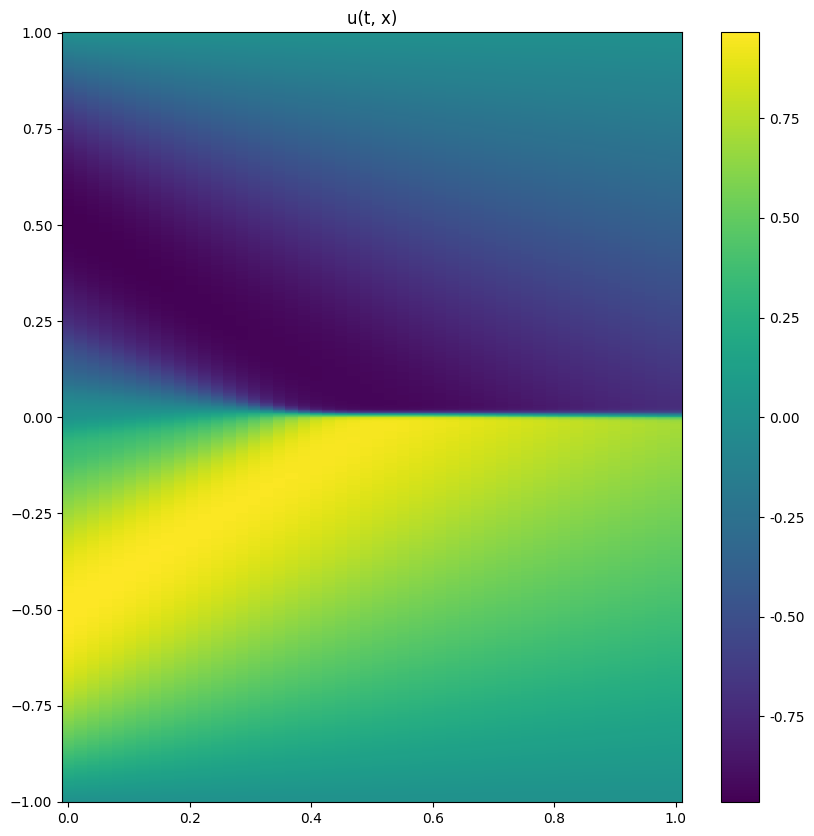

In [18]:
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

u_est = lambda t_x: u(t_x, params.nn_params)

jinns.plot.plot1d_image(
    u_est,
    xdata=val_xdata,
    times=val_times,
    cmap="viridis",
    colorbar=True,
    figsize=(10, 10),
    title="u(t, x)",
)

## The stationary case

In case of a stationnary PDE, you may replace 
 * The PINN creation by the following call: `jinns.nn.PINN_MLP.create(key=key, eqx_list=eqx_list, eq_type="statio_PDE")` which returns a PINN object with the `__call__` function to call `u(x, params)` without the `t` input, as well as the initial parameters. The dimension of the first layer of the network must be equal to $d$ in this case.
 * The `DataGenerator` in order to return only batch on $\Omega \times \partial \Omega$. See `CubicMeshPDEStatio` class.
 * The `LossPDENonStatio` class by the `LossPDEStatio` class (see the documentation and examples)